In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Input, Lambda
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import cv2

2025-06-26 18:06:40.724596: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-06-26 18:06:40.724723: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-06-26 18:06:40.910219: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
train_dataset = pd.read_csv('/kaggle/input/signature-verification-dataset/sign_data/train_data.csv', header = None)
test_dataset = pd.read_csv('/kaggle/input/signature-verification-dataset/sign_data/test_data.csv', header = None)  
train_dir = "/kaggle/input/signature-verification-dataset/sign_data/train"
test_dir = "/kaggle/input/signature-verification-dataset/sign_data/test"

In [3]:
class DataLoader:
    def __init__(self, dataset, batch_size, dir):
        self.dataset = dataset
        self.batch_size = batch_size
        self.dir = dir
    def shuffle(self):
        return self.dataset.sample(frac=1)
    
    def preprocess_image(self, img_path):
        img = tf.io.read_file(img_path)
        img = tf.image.decode_png(img, channels=1) 
        img = tf.image.resize(img, (128, 128))
        img = tf.cast(img, tf.uint8) 
        img_cv2 = cv2.Canny(img.numpy(), 20, 220) 
        img_cv2 = tf.cast(img_cv2, tf.float32) / 255.0
        return img_cv2
    
    def datagen(self):
        num_samples = len(self.dataset)
        while True:
            self.dataset = self.shuffle()
            for batch in range(0, num_samples, self.batch_size):
                image1_batch_samples = [self.dir + "/" + img for img in self.dataset.iloc[batch:batch + self.batch_size, 0]]
                image2_batch_samples = [self.dir + "/" + img for img in self.dataset.iloc[batch:batch + self.batch_size, 1]]
                label_batch_samples = self.dataset.iloc[batch:batch + self.batch_size, 2]
                Image1, Image2, Label = [], [], []
                for image1, image2, label in zip(image1_batch_samples, image2_batch_samples, label_batch_samples):
                    image1_data = self.preprocess_image(image1)
                    image2_data = self.preprocess_image(image2)
                    Image1.append(image1_data)
                    Image2.append(image2_data)
                    Label.append(label)
                Image1 = np.asarray(Image1)
                Image2 = np.asarray(Image2)
                Label = np.asarray(Label)
                yield {"image1": Image1, "image2": Image2}, Label


In [4]:
train_set, val_set = train_test_split(train_dataset, test_size=0.25)
train_gen = DataLoader(train_set, 256, train_dir)
val_gen = DataLoader(val_set, 256, train_dir)
test_gen = DataLoader(test_dataset, 256, test_dir)  

Pair 1:
Label: 0


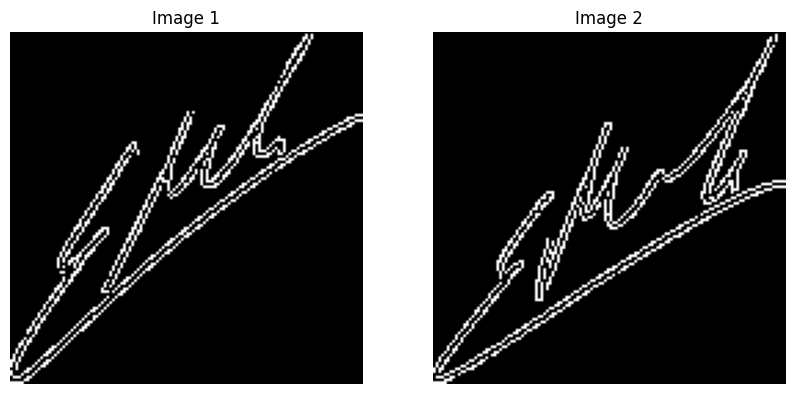

Pair 2:
Label: 1


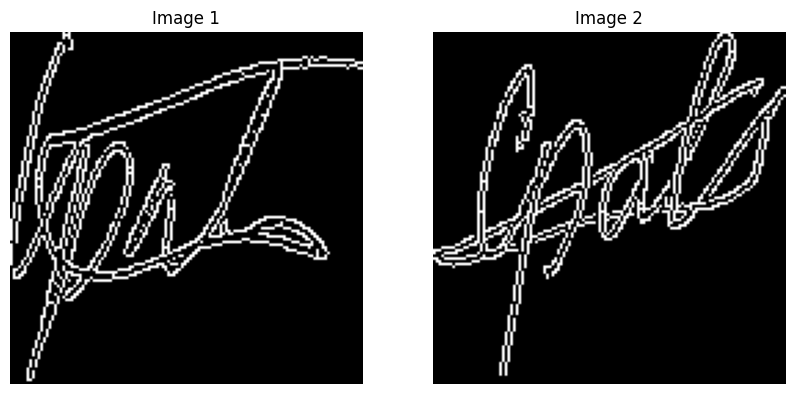

Pair 3:
Label: 0


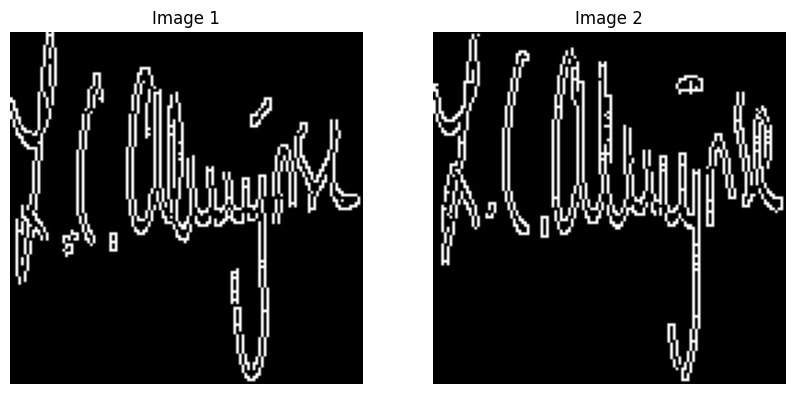

Pair 4:
Label: 0


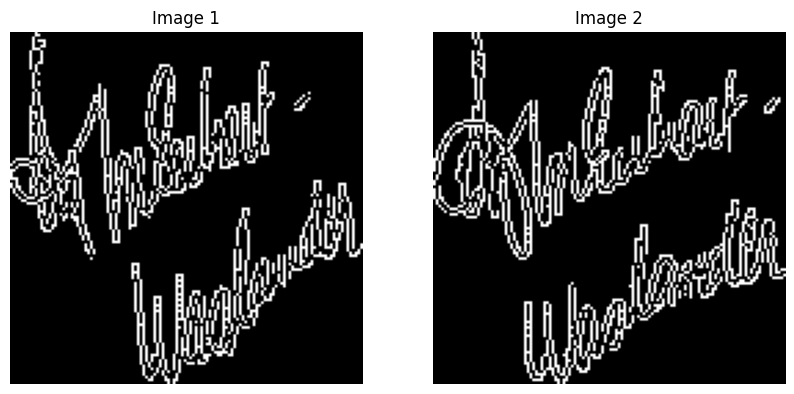

Pair 5:
Label: 1


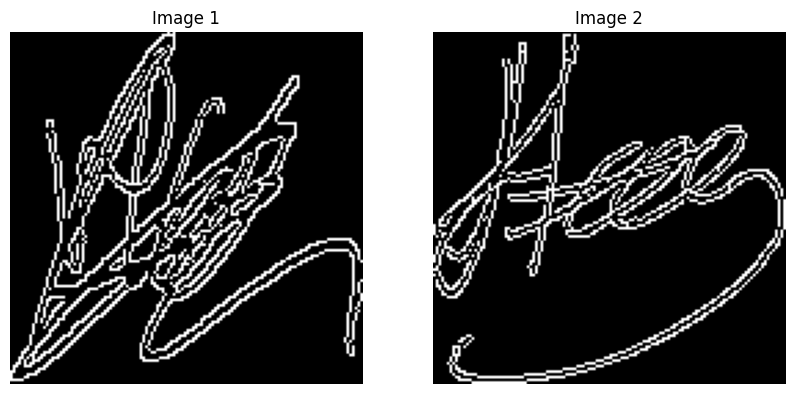

In [5]:
generator = train_gen.datagen()
for i in range(5):
    batch_data, label = next(generator)
    pair_data = batch_data["image1"], batch_data["image2"]
    print(f"Pair {i+1}:")
    print("Label:", label[0]) 
    plt.figure(figsize=(10, 5))
    for j in range(2):
        plt.subplot(1, 2, j+1)
        plt.imshow(pair_data[j][0], cmap='gray')
        plt.title('Image {}'.format(j+1))
        plt.axis('off')
    plt.show()

In [13]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, BatchNormalization, Flatten, Dense, Lambda, Concatenate
import tensorflow as tf

def create_siamese_model(input_shape):
    def build_base_cnn(input_shape):
        inp = Input(shape=input_shape)
        x = Conv2D(16, (3, 3), activation='relu')(inp)
        x = BatchNormalization()(x)
        x = MaxPooling2D(2, 2)(x)
        x = Dropout(0.25)(x)

        x = Conv2D(32, (3, 3), activation='relu')(x)
        x = BatchNormalization()(x)
        x = MaxPooling2D(2, 2)(x)
        x = Dropout(0.25)(x)

        x = Conv2D(64, (3, 3), activation='relu')(x)
        x = BatchNormalization()(x)
        x = MaxPooling2D(2, 2)(x)
        x = Dropout(0.25)(x)

        x = Conv2D(128, (3, 3), activation='relu')(x)
        x = BatchNormalization()(x)
        x = MaxPooling2D(2, 2)(x)
        x = Dropout(0.25)(x)

        x = Flatten()(x)
        x = Dense(512, activation='relu')(x)
        x = Dense(128, activation='relu')(x)

        return Model(inp, x)

    base_cnn = build_base_cnn(input_shape)

    input1 = Input(shape=input_shape, name="image1")
    input2 = Input(shape=input_shape, name="image2")

    embedding1 = base_cnn(input1)
    embedding2 = base_cnn(input2)

    l1_distance = Lambda(lambda tensors: tf.abs(tensors[0] - tensors[1]))([embedding1, embedding2])
    mult_distance = Lambda(lambda tensors: tensors[0] * tensors[1])([embedding1, embedding2])

    merged = Concatenate()([l1_distance, mult_distance])
    output = Dense(1, activation='sigmoid')(merged)

    return Model(inputs=[input1, input2], outputs=output)


In [14]:
input_shape = (128, 128, 1) 

In [15]:
model = create_siamese_model(input_shape)
model.summary()
model.compile(loss="binary_crossentropy", optimizer='adam', metrics=['accuracy'])

Model: "functional_20"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image1 (InputLayer) │ (None, 128, 128,  │          0 │ -                 │
│                     │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ image2 (InputLayer) │ (None, 128, 128,  │          0 │ -                 │
│                     │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_18       │ (None, 128)       │  2,523,584 │ image1[0][0],     │
│ (Functional)        │                   │            │ image2[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_1 (Lambda)   │ (None, 128)       │          0 │ functional_18[0]… │
│                     │                   │            │ functional_18[1]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_2 (Lambda)   │ (None, 128)       │          0 │ functional_18[0]… │
│                     │                   │            │ functional_18[1]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 256)       │          0 │ lambda_1[0][0],   │
│ (Concatenate)       │                   │            │ lambda_2[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 1)         │        257 │ concatenate[0][0] │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,523,841 (9.63 MB)

 Trainable params: 2,523,361 (9.63 MB)

 Non-trainable params: 480 (1.88 KB)

In [18]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    verbose=1,
    min_lr=1e-6
)
checkpoint = ModelCheckpoint("signature_model_siamese.keras", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

callbacks_list = [checkpoint, reduce_lr]

In [20]:
history = model.fit(x=train_gen.datagen(),
                            steps_per_epoch=len(train_set) // 256,
                            epochs=30,
                            validation_data=val_gen.datagen(),
                            validation_steps=len(val_set) // 256,
                            callbacks=callbacks_list)

Epoch 1/30
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9685 - loss: 0.0900
Epoch 1: val_accuracy improved from 0.53354 to 0.68857, saving model to signature_model_siamese.keras
67/67 ━━━━━━━━━━━━━━━━━━━━ 283s 4s/step - accuracy: 0.9685 - loss: 0.0899 - val_accuracy: 0.6886 - val_loss: 2.9801 - learning_rate: 0.0010
Epoch 2/30
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9808 - loss: 0.0572
Epoch 2: val_accuracy improved from 0.68857 to 0.81122, saving model to signature_model_siamese.keras
67/67 ━━━━━━━━━━━━━━━━━━━━ 254s 4s/step - accuracy: 0.9809 - loss: 0.0571 - val_accuracy: 0.8112 - val_loss: 1.1249 - learning_rate: 0.0010
Epoch 3/30
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9891 - loss: 0.0335
Epoch 3: val_accuracy improved from 0.81122 to 0.84692, saving model to signature_model_siamese.keras
67/67 ━━━━━━━━━━━━━━━━━━━━ 246s 4s/step - accuracy: 0.9891 - loss: 0.0334 - val_accuracy: 0.8469 - val_loss: 0.9430 - learning_rate: 0.0010
Epoch 4/30
67/67 ━━━━━━━━

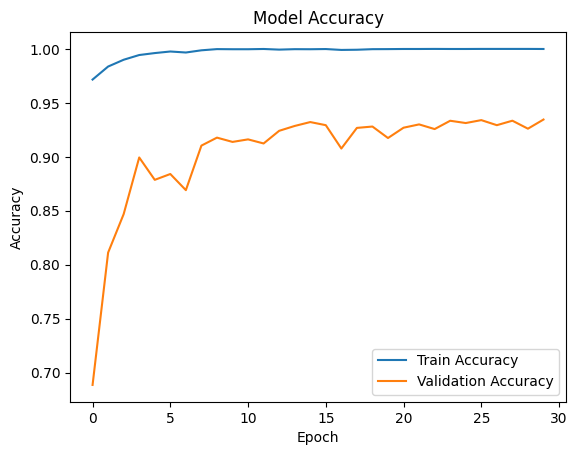

In [21]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')
plt.legend()
plt.show()

In [22]:
model.load_weights("/kaggle/working/signature_model_siamese.keras")

In [24]:
test_dir = "sign_data/test"
test_dataset = pd.read_csv('/kaggle/input/signature-verification-dataset/sign_data/test_data.csv', header = None)

In [25]:
test_loss, test_accuracy = model.evaluate(test_gen.datagen(),
                                          steps=len(test_dataset) // 256)

22/22 ━━━━━━━━━━━━━━━━━━━━ 63s 3s/step - accuracy: 0.9429 - loss: 0.2200


In [26]:
test_pairs, test_labels = next(test_gen.datagen())

In [27]:
print(test_loss, test_accuracy)
test_predictions = model.predict(test_pairs)

binary_predictions = (test_predictions > 0.5).astype(int)

0.23262014985084534 0.9422940611839294


2025-06-26 20:36:21.190647: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 31760: 1.20333, expected 0.936857
2025-06-26 20:36:21.190717: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 31761: 1.62844, expected 1.36197
2025-06-26 20:36:21.190727: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 31762: 1.61654, expected 1.35007
2025-06-26 20:36:21.190735: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 31763: 1.51099, expected 1.24452
2025-06-26 20:36:21.190743: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 31764: 1.35685, expected 1.09038
2025-06-26 20:36:21.190751: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 31781: 1.18108, expected 0.914609
2025-06-26 20:36:21.190759: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 31783: 1.26446, expected 0.997985
2025-06-26 20:36:21.1907

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


W0000 00:00:1750970181.932319     106 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


Pair 252
True Label: 1
Predicted Label: [1]


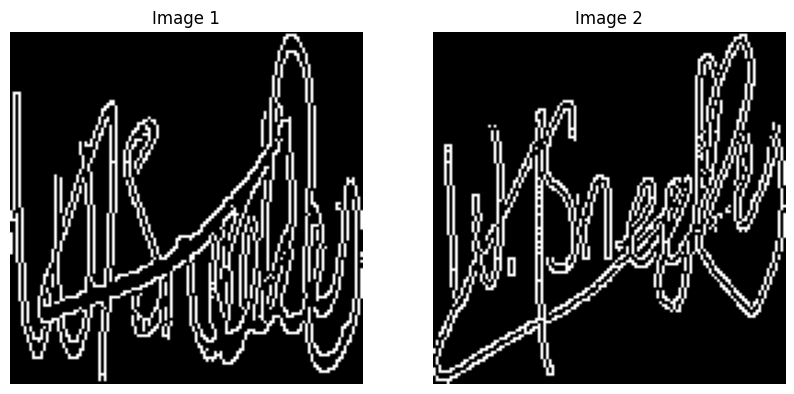

Pair 117
True Label: 1
Predicted Label: [1]


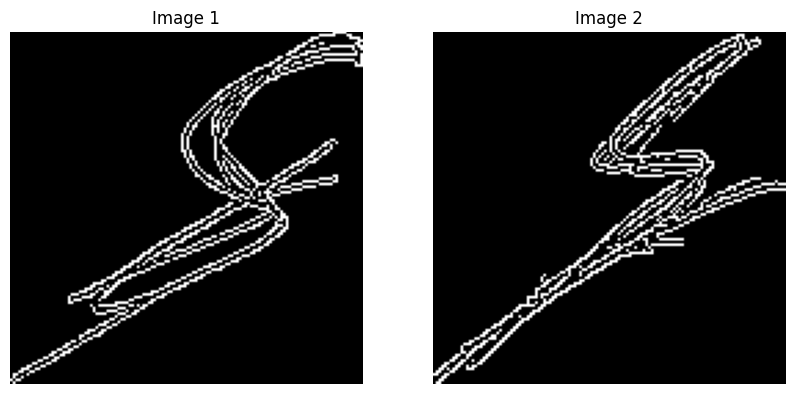

Pair 215
True Label: 1
Predicted Label: [1]


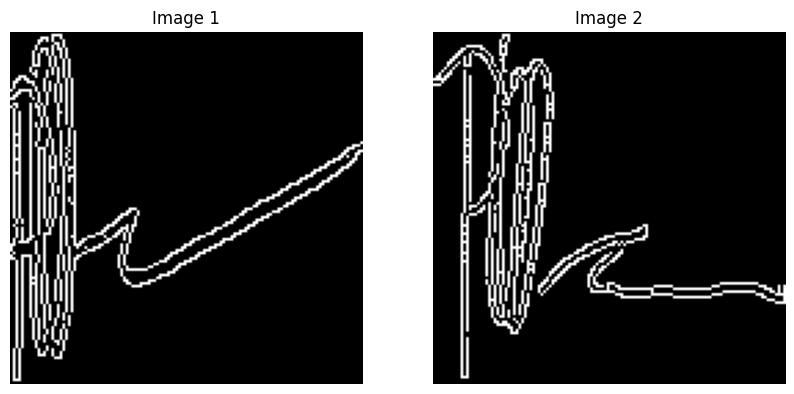

Pair 251
True Label: 1
Predicted Label: [1]


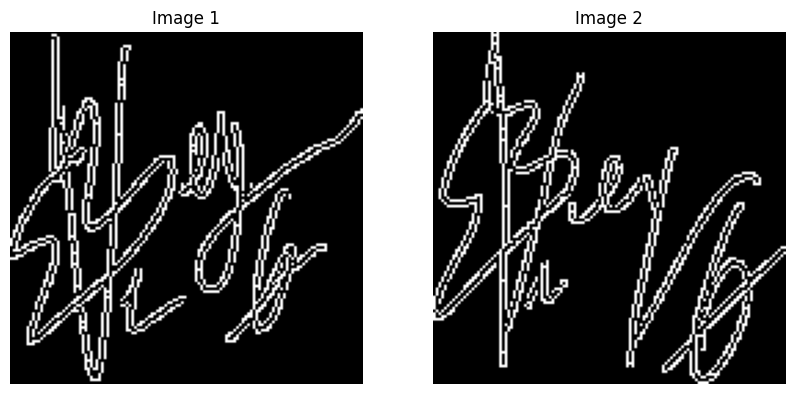

Pair 185
True Label: 1
Predicted Label: [1]


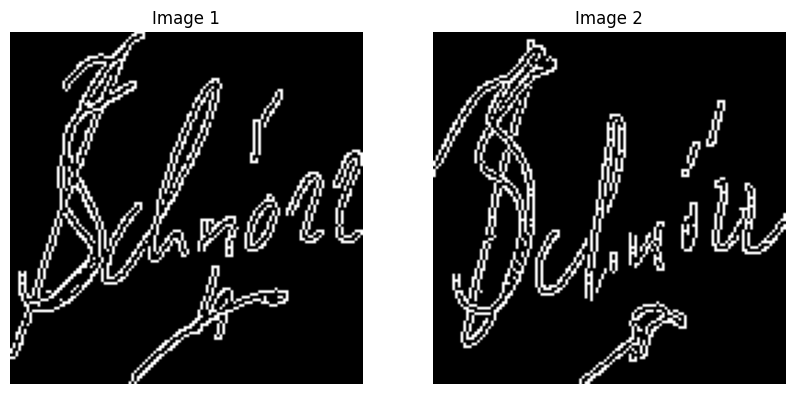

Pair 98
True Label: 0
Predicted Label: [0]


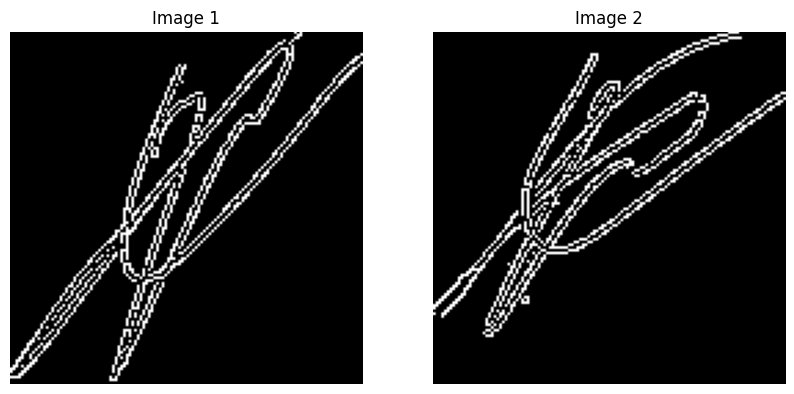

Pair 224
True Label: 1
Predicted Label: [1]


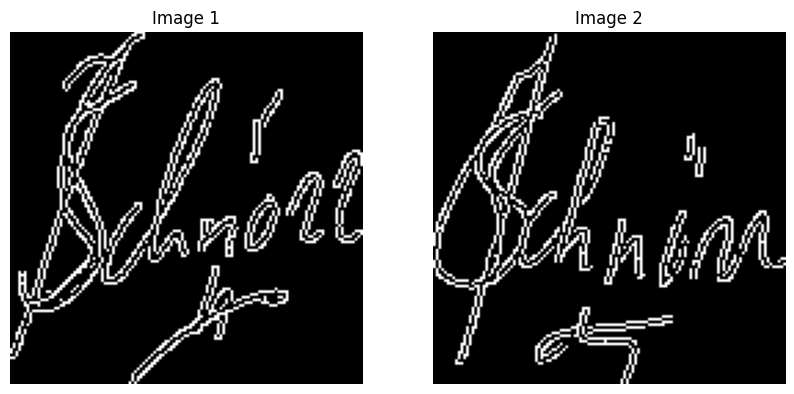

Pair 100
True Label: 0
Predicted Label: [0]


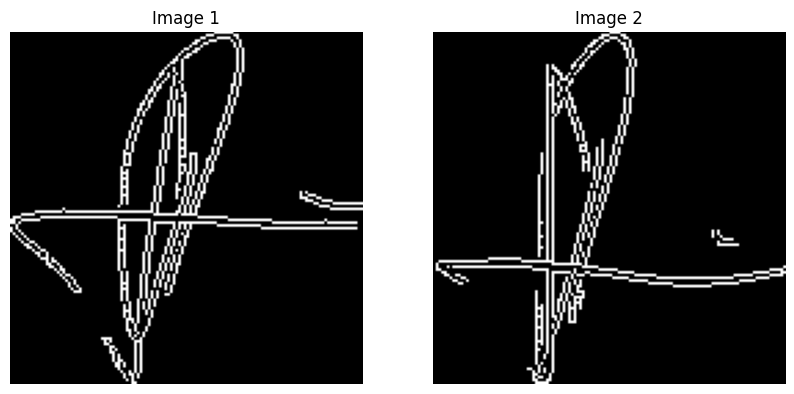

Pair 245
True Label: 1
Predicted Label: [1]


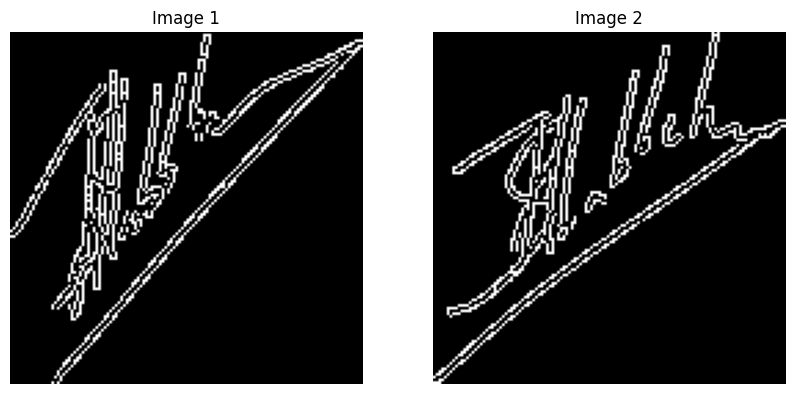

Pair 80
True Label: 1
Predicted Label: [1]


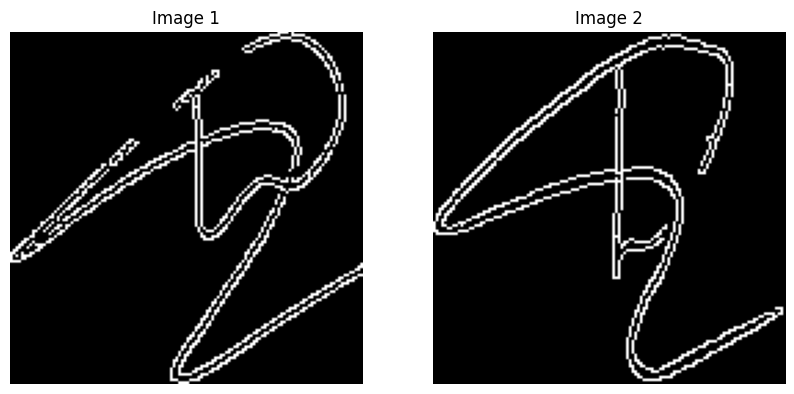

Pair 137
True Label: 1
Predicted Label: [1]


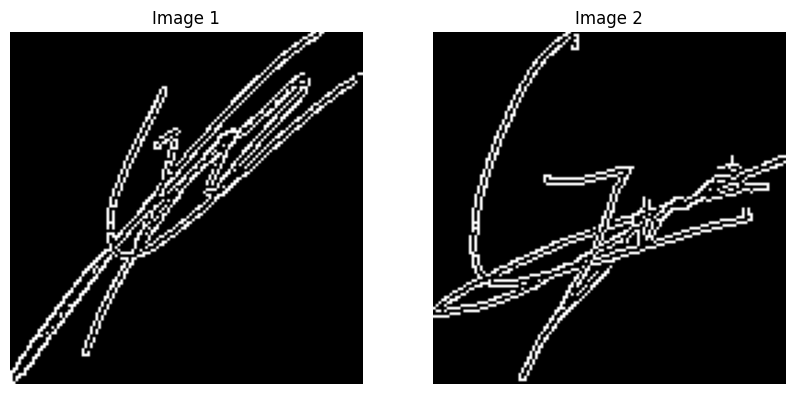

Pair 250
True Label: 1
Predicted Label: [0]


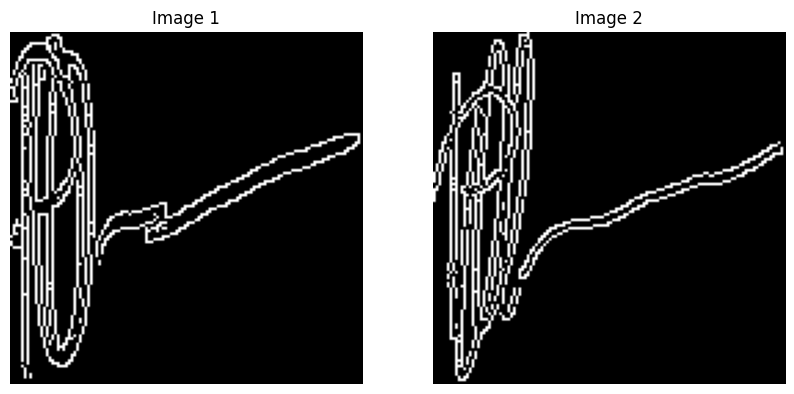

Pair 84
True Label: 0
Predicted Label: [0]


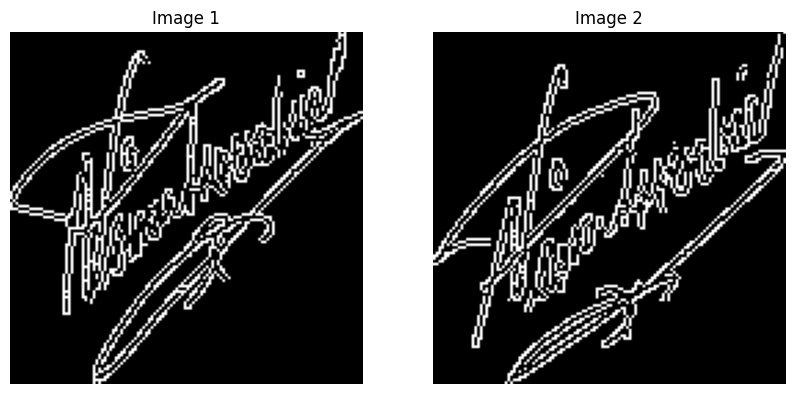

Pair 111
True Label: 0
Predicted Label: [0]


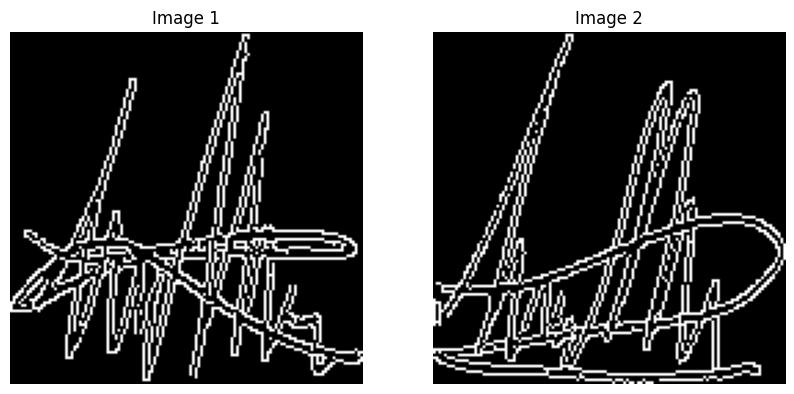

Pair 101
True Label: 1
Predicted Label: [1]


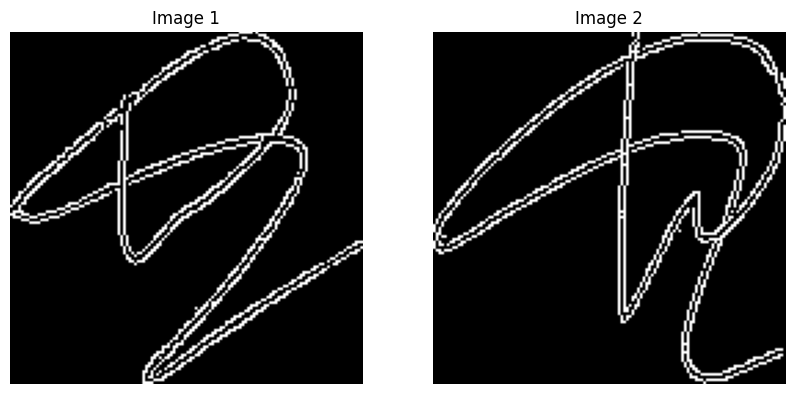

Pair 133
True Label: 1
Predicted Label: [1]


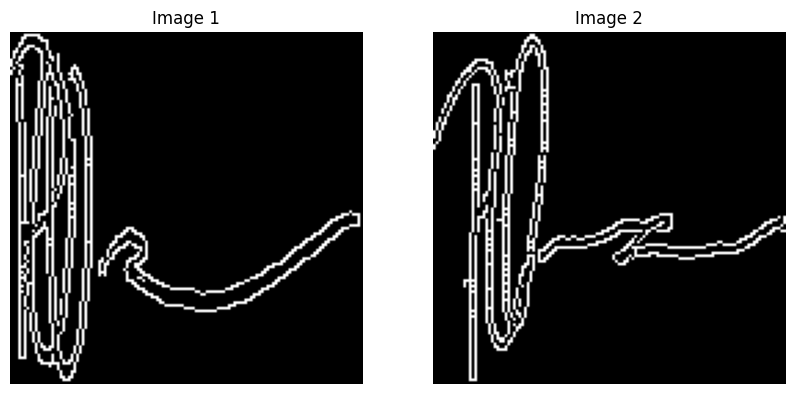

Pair 32
True Label: 1
Predicted Label: [1]


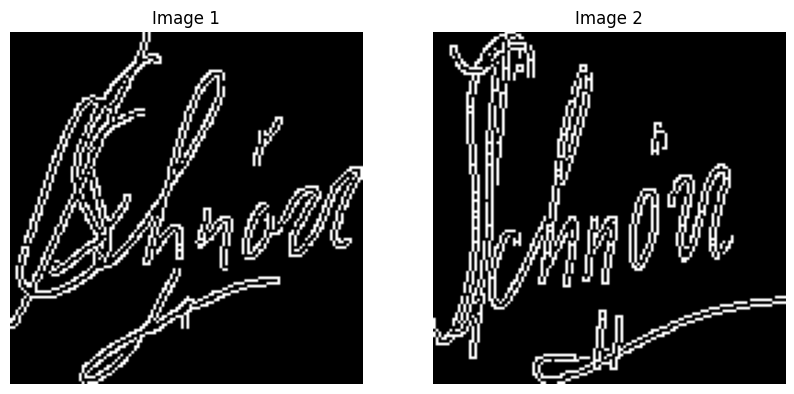

Pair 249
True Label: 1
Predicted Label: [1]


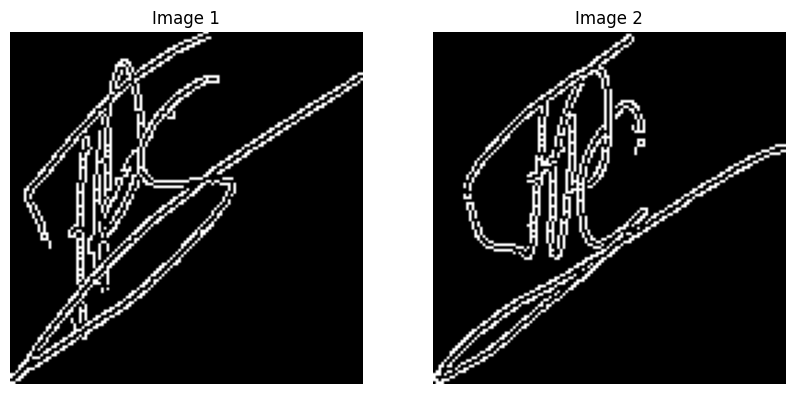

Pair 87
True Label: 1
Predicted Label: [1]


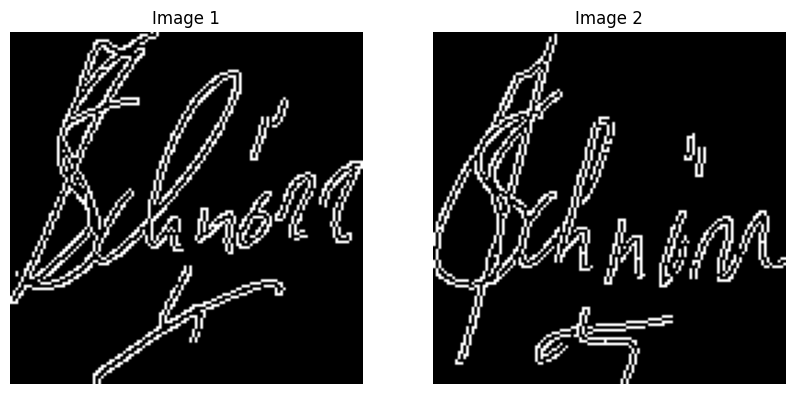

Pair 158
True Label: 1
Predicted Label: [1]


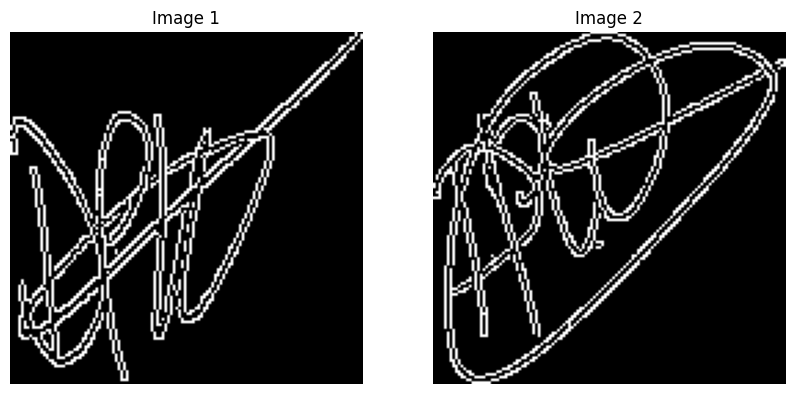

In [28]:
import random
random_indices = random.sample(range(len(test_pairs['image1'])), 20)
for i in random_indices:
    image1 = test_pairs['image1'][i]
    image2 = test_pairs['image2'][i]
    true_label = test_labels[i]
    predicted_label = binary_predictions[i]
    
    print("Pair", i+1)
    print("True Label:", true_label)
    print("Predicted Label:", predicted_label)
    
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(image1.squeeze(), cmap='gray')
    plt.title('Image 1')
    plt.axis('off')
    plt.subplot(1, 2, 2)
    plt.imshow(image2.squeeze(), cmap='gray')
    plt.title('Image 2')
    plt.axis('off')
    plt.show()